In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
%matplotlib inline

/Users/vbd402/Documents/Projects/mixedbridge


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from src.solvers.euler import Euler
from src.stochastic_processes.abstract_processes.wiener_process import WienerProcess
from src.stochastic_processes.cell_model import CellDiffusionProcess, CellDiffusionProcessAux
from src.stochastic_processes.abstract_processes.guided_bridge_process import GuidedBridgeProcess
from src.mcmc.pcn import PreconditionedCrankNicolson

In [3]:
dim = 2
alpha = 1. / 16.
sigma = .1
T = 4.0
dt = 1./500
dtype = jnp.float32
rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.1, -0.1], dtype=dtype)

In [4]:
wiener_process = WienerProcess(dim, dtype, rng_key)
sde = CellDiffusionProcess(alpha, sigma, T=T, dt=dt)
solver = Euler(sde)

dWs = wiener_process.sample_path(sde.ts).xs
path = solver.solve(x0, dWs=dWs)

Text(0.5, 1.0, 'Unconditional process')

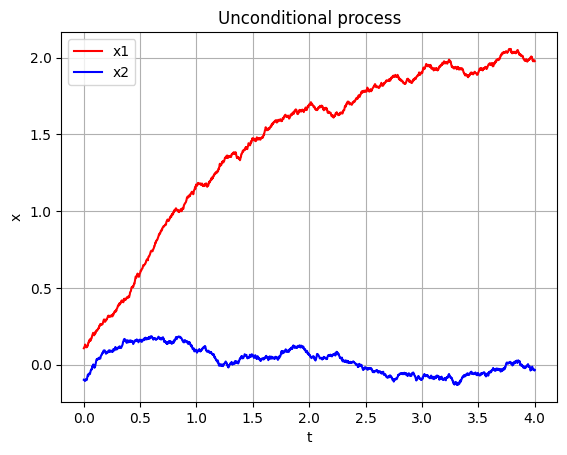

In [6]:
plt.plot(path.ts, path.xs[:, 0], label='x1', color='r')
plt.plot(path.ts, path.xs[:, 1], label='x2', color='b')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()
plt.title("Unconditional process")

In [7]:
aux_sde = CellDiffusionProcessAux(alpha, sigma, T=4.0, dt=1./500.)
L0 = jnp.eye(dim, dtype=dtype)
x0 = jnp.array([0.1, -0.1], dtype=dtype)
xT = jnp.array([2.0, -0.1], dtype=dtype)
Sigma0 = jnp.eye(dim, dtype=dtype) * 1e-10
guided_sde = GuidedBridgeProcess(sde, aux_sde, L0, Sigma0, start=x0, target=xT)
solver = Euler(guided_sde)
path = solver.solve(x0, dWs=dWs, log_likelihood=True)

Text(0.5, 1.0, 'Guided process')

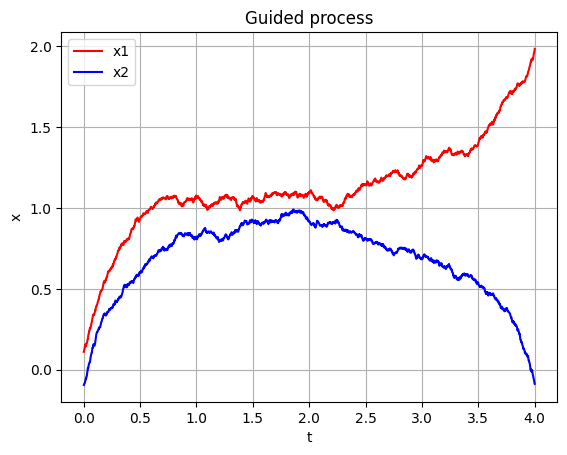

In [8]:
plt.plot(path.ts, path.xs[:, 0], label='x1', color='r')
plt.plot(path.ts, path.xs[:, 1], label='x2', color='b')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()
plt.title("Guided process")

In [9]:
mcmc_model = PreconditionedCrankNicolson(
    rho=0.98,
    x0=x0,
    guided_process=guided_sde,
    rng_key=rng_key,
)

In [15]:
path_mcmc, lls = mcmc_model.update(n_iters=2000, verbose=True, log_every=50)

Iteration 50/2000: log likelihood = 132.41094970703125, accepted = True
Iteration 100/2000: log likelihood = 146.83880615234375, accepted = True
Iteration 150/2000: log likelihood = 159.91339111328125, accepted = True
Iteration 200/2000: log likelihood = 165.27638244628906, accepted = False
Iteration 250/2000: log likelihood = 168.11715698242188, accepted = True
Iteration 300/2000: log likelihood = 167.28741455078125, accepted = True
Iteration 350/2000: log likelihood = 165.7971954345703, accepted = False
Iteration 400/2000: log likelihood = 163.93638610839844, accepted = True
Iteration 450/2000: log likelihood = 169.0863800048828, accepted = True
Iteration 500/2000: log likelihood = 162.32968139648438, accepted = True
Iteration 550/2000: log likelihood = 156.31475830078125, accepted = False
Iteration 600/2000: log likelihood = 153.81492614746094, accepted = False
Iteration 650/2000: log likelihood = 153.77816772460938, accepted = False
Iteration 700/2000: log likelihood = 155.39517211

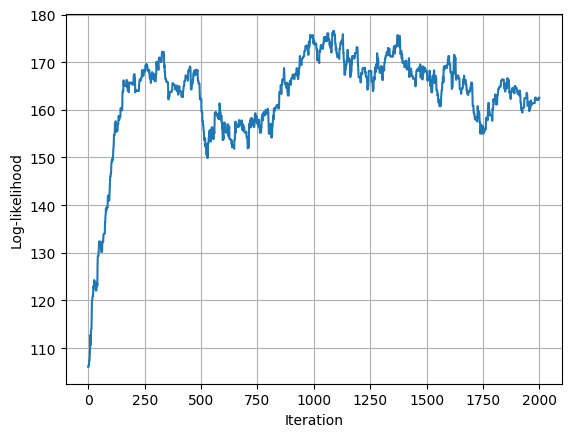

In [16]:
plt.plot(lls)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.grid()

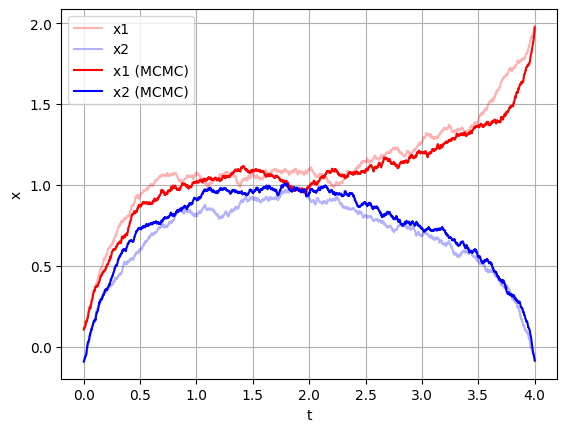

In [17]:
plt.plot(path.ts, path.xs[:, 0], label='x1', color='r', alpha=0.3)
plt.plot(path.ts, path.xs[:, 1], label='x2', color='b', alpha=0.3)
plt.plot(path_mcmc.ts, path_mcmc.xs[:, 0], label='x1 (MCMC)', color='r')
plt.plot(path_mcmc.ts, path_mcmc.xs[:, 1], label='x2 (MCMC)', color='b')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()